In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2023-02-01 15:03:16.522979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:03:17.399785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 15:03:17.399849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 15:03:17.399857: W tensorflow/compiler/tf2t

2.11.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_pred_file = "concept_prediction_train.csv"
concept_file = "concepts.csv"

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concepts = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()

In [5]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation + "¿"

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [6]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
print("Vocab size:")
print(len(set(result.split())))

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
print("Longest sequence:")
print(len(longest))

2023-02-01 15:03:19.420157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:03:19.424993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:03:19.425232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 15:03:19.425746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Vocab size:
35489
Longest sequence:
391


In [11]:
def load_data(limit=0):
    images = []
    _max = 0
    
    files = [filename for filename in os.listdir(image_dir)]
    if limit != 0:
        files = random.sample(files, limit)
        
    for filename in files:
        name = os.path.splitext(filename)[0]
        if name not in captions:
            continue

        image_path = os.path.join(image_dir, name + ".jpg")
        image = cv2.imread(image_path)

        # Preprocess images
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        
        # Preprocess texts
        text = captions[name]
        text = "[SOS] " + text + " [EOS]"
        text = text_vectorization(captions[name])
        
        images.append((image, text))
            
    return images

def load_dataset(limit=0, test=0.2, val=0.0):
    image_pairs = load_data(limit)
    
    random.shuffle(image_pairs)
    num_test_samples = int(test * len(image_pairs))
    num_val_samples = int(val * len(image_pairs))
    test_pairs = image_pairs[:num_test_samples]
    val_pairs = image_pairs[num_test_samples : num_test_samples + num_val_samples]
    train_pairs = image_pairs[num_test_samples + num_val_samples :]
    
    return train_pairs, val_pairs, test_pairs

def visualize_dataset(dataset, nums=5):
    for n, (i, t) in enumerate(random.sample(dataset, nums)):
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, n + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [8]:
vocab_size = 35491
sequence_length = 393

text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [v for v in captions.values()]
text_vectorization.adapt(train_captions)

In [9]:
ds_train, ds_val, ds_test = load_dataset(100)

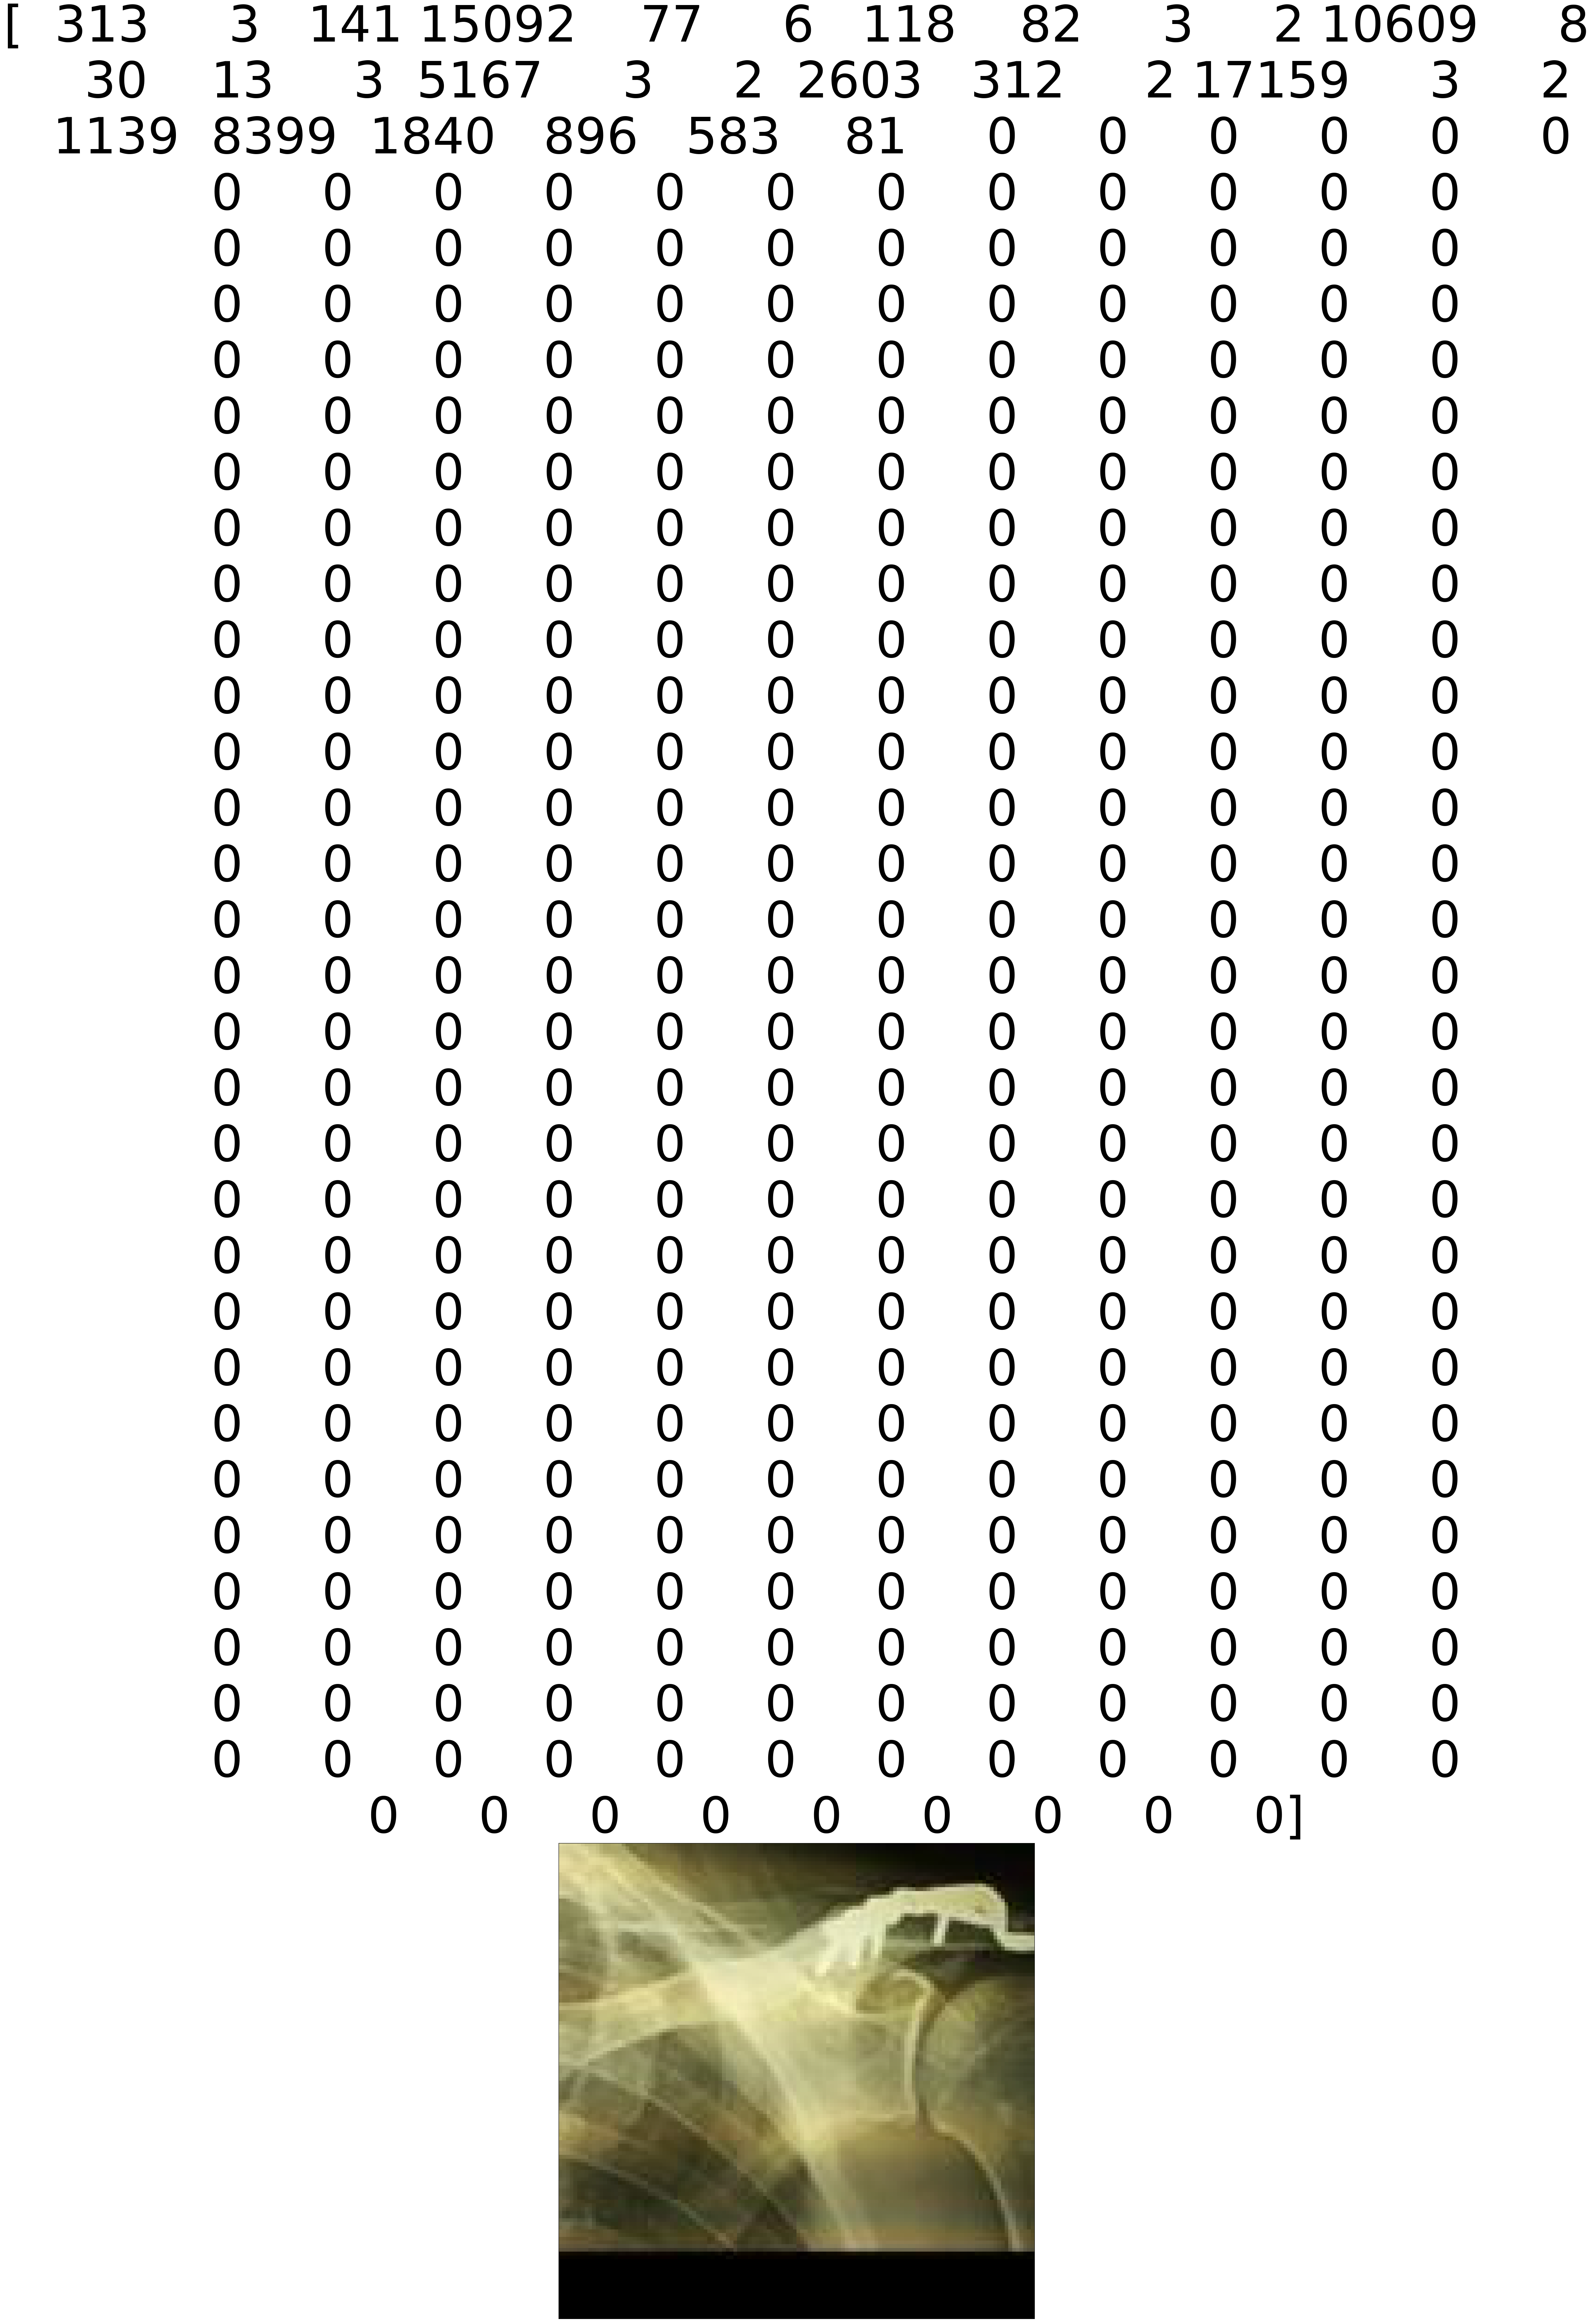

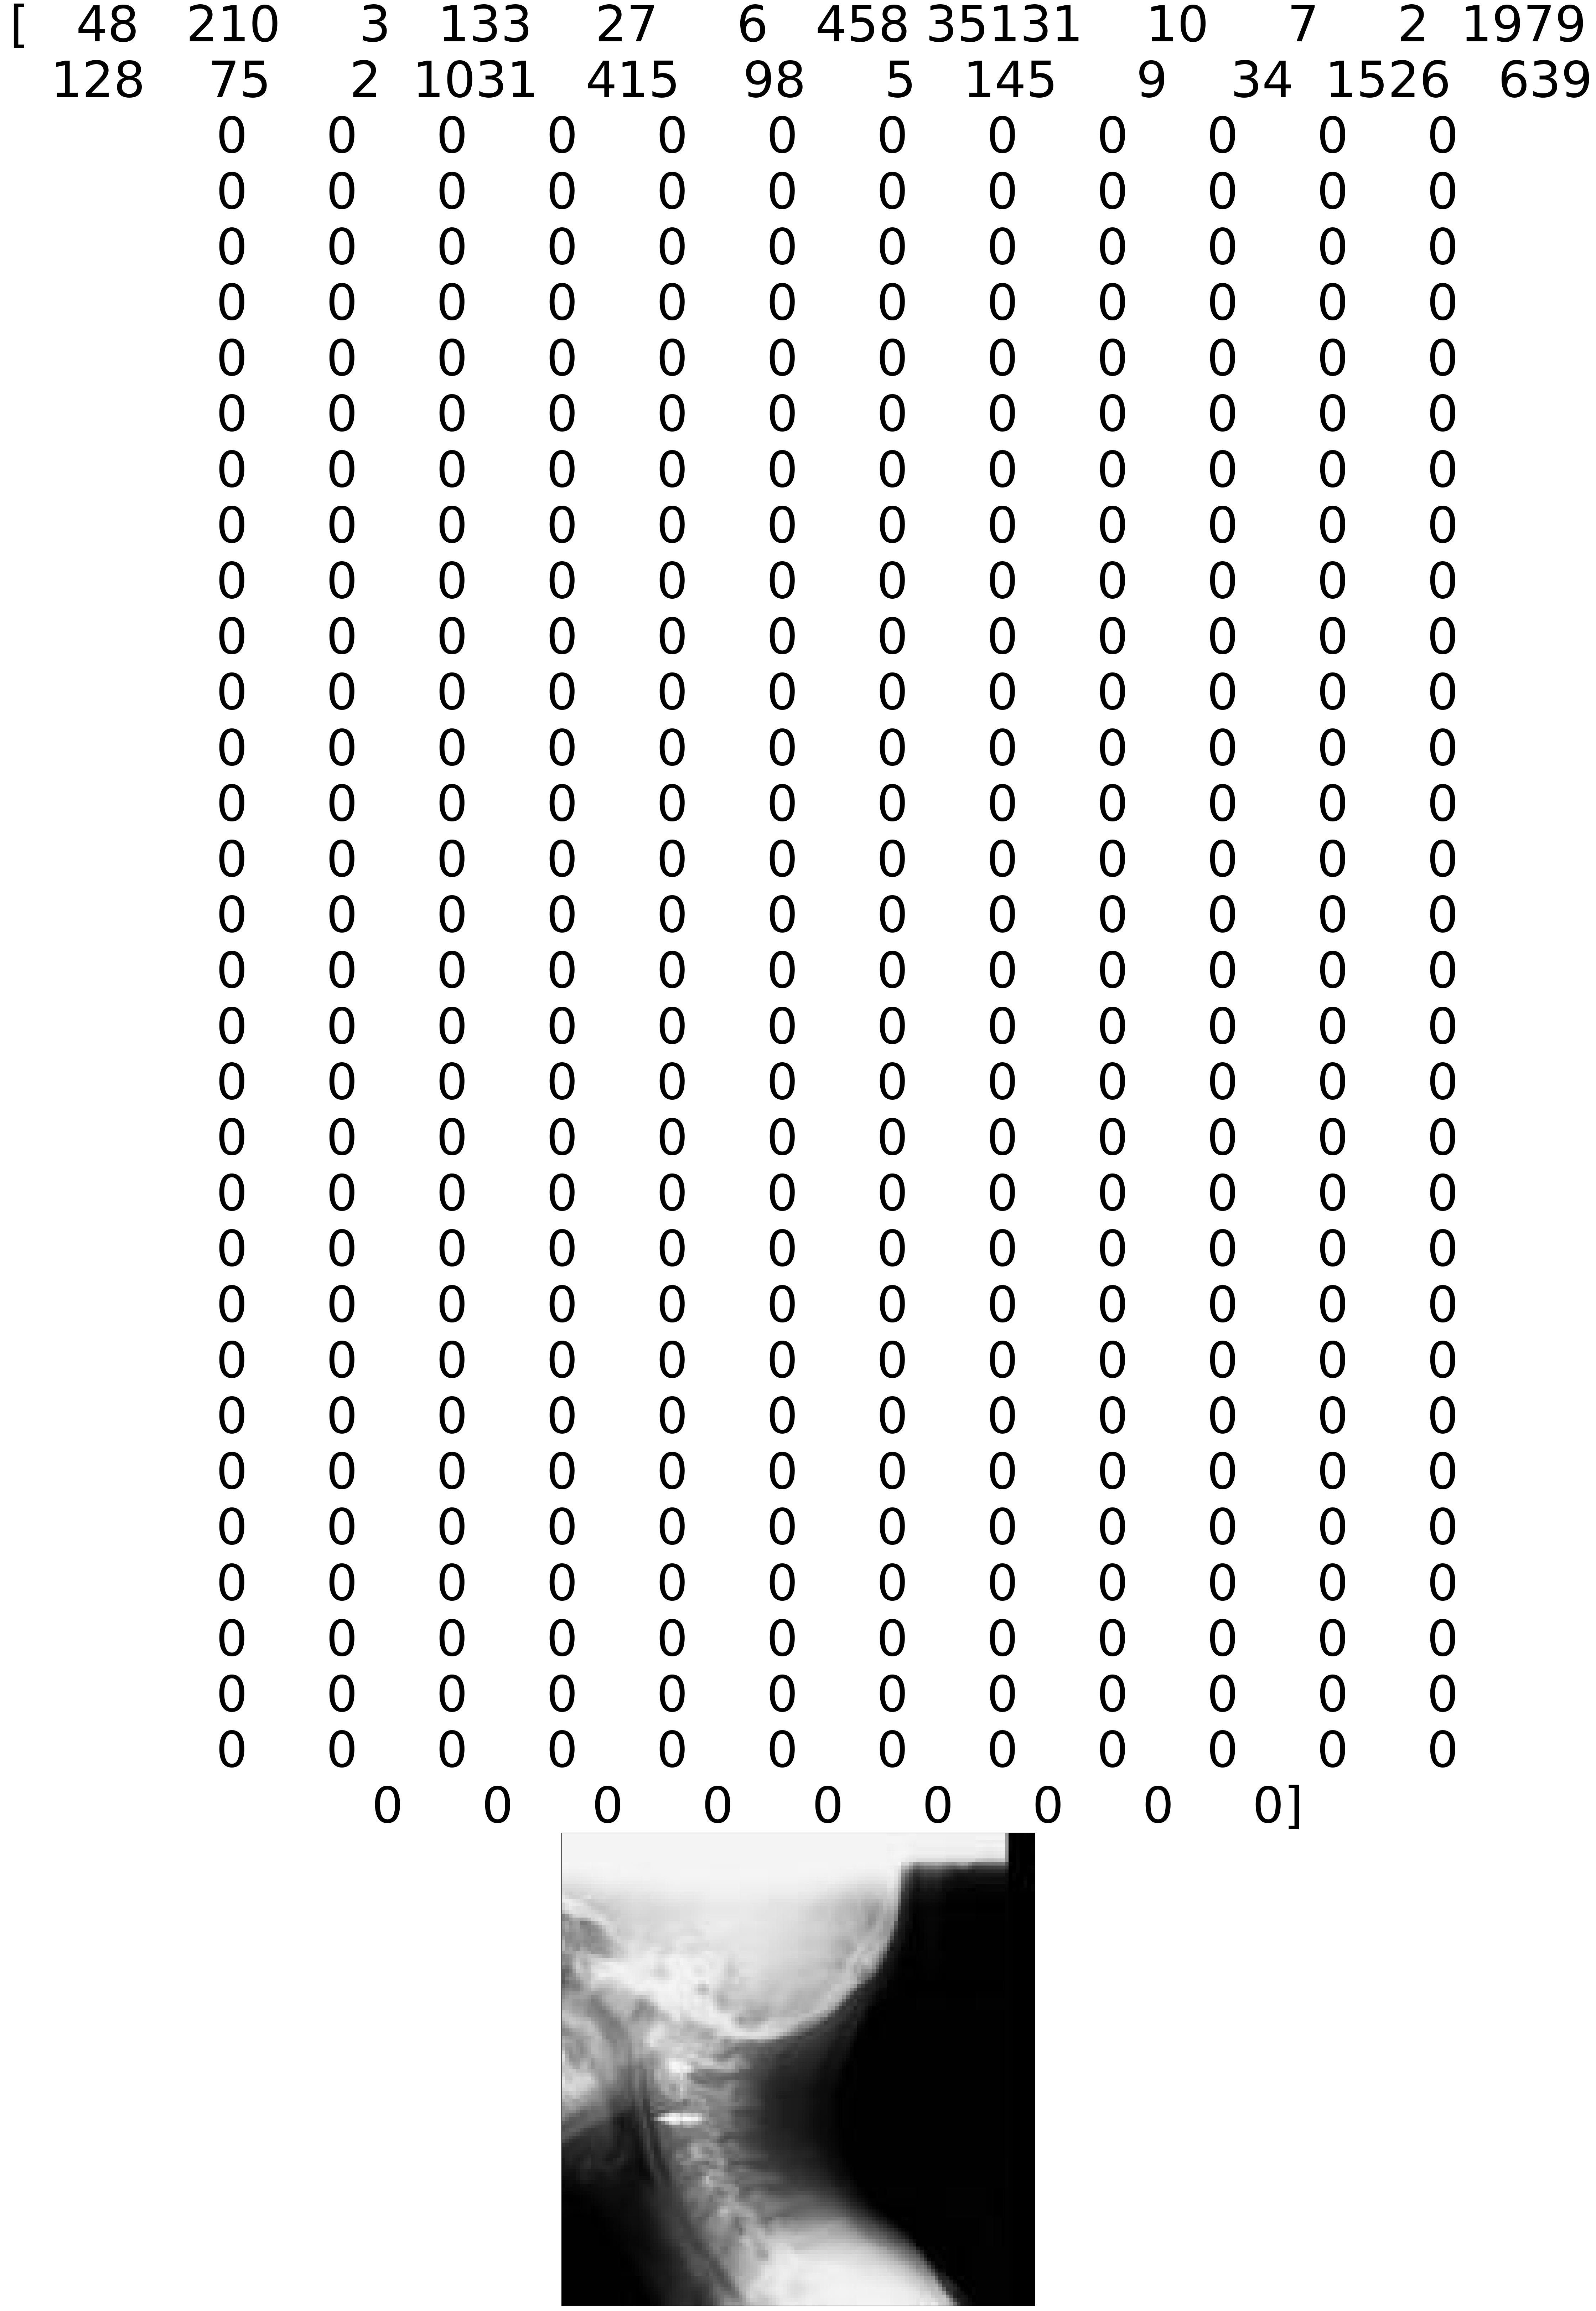

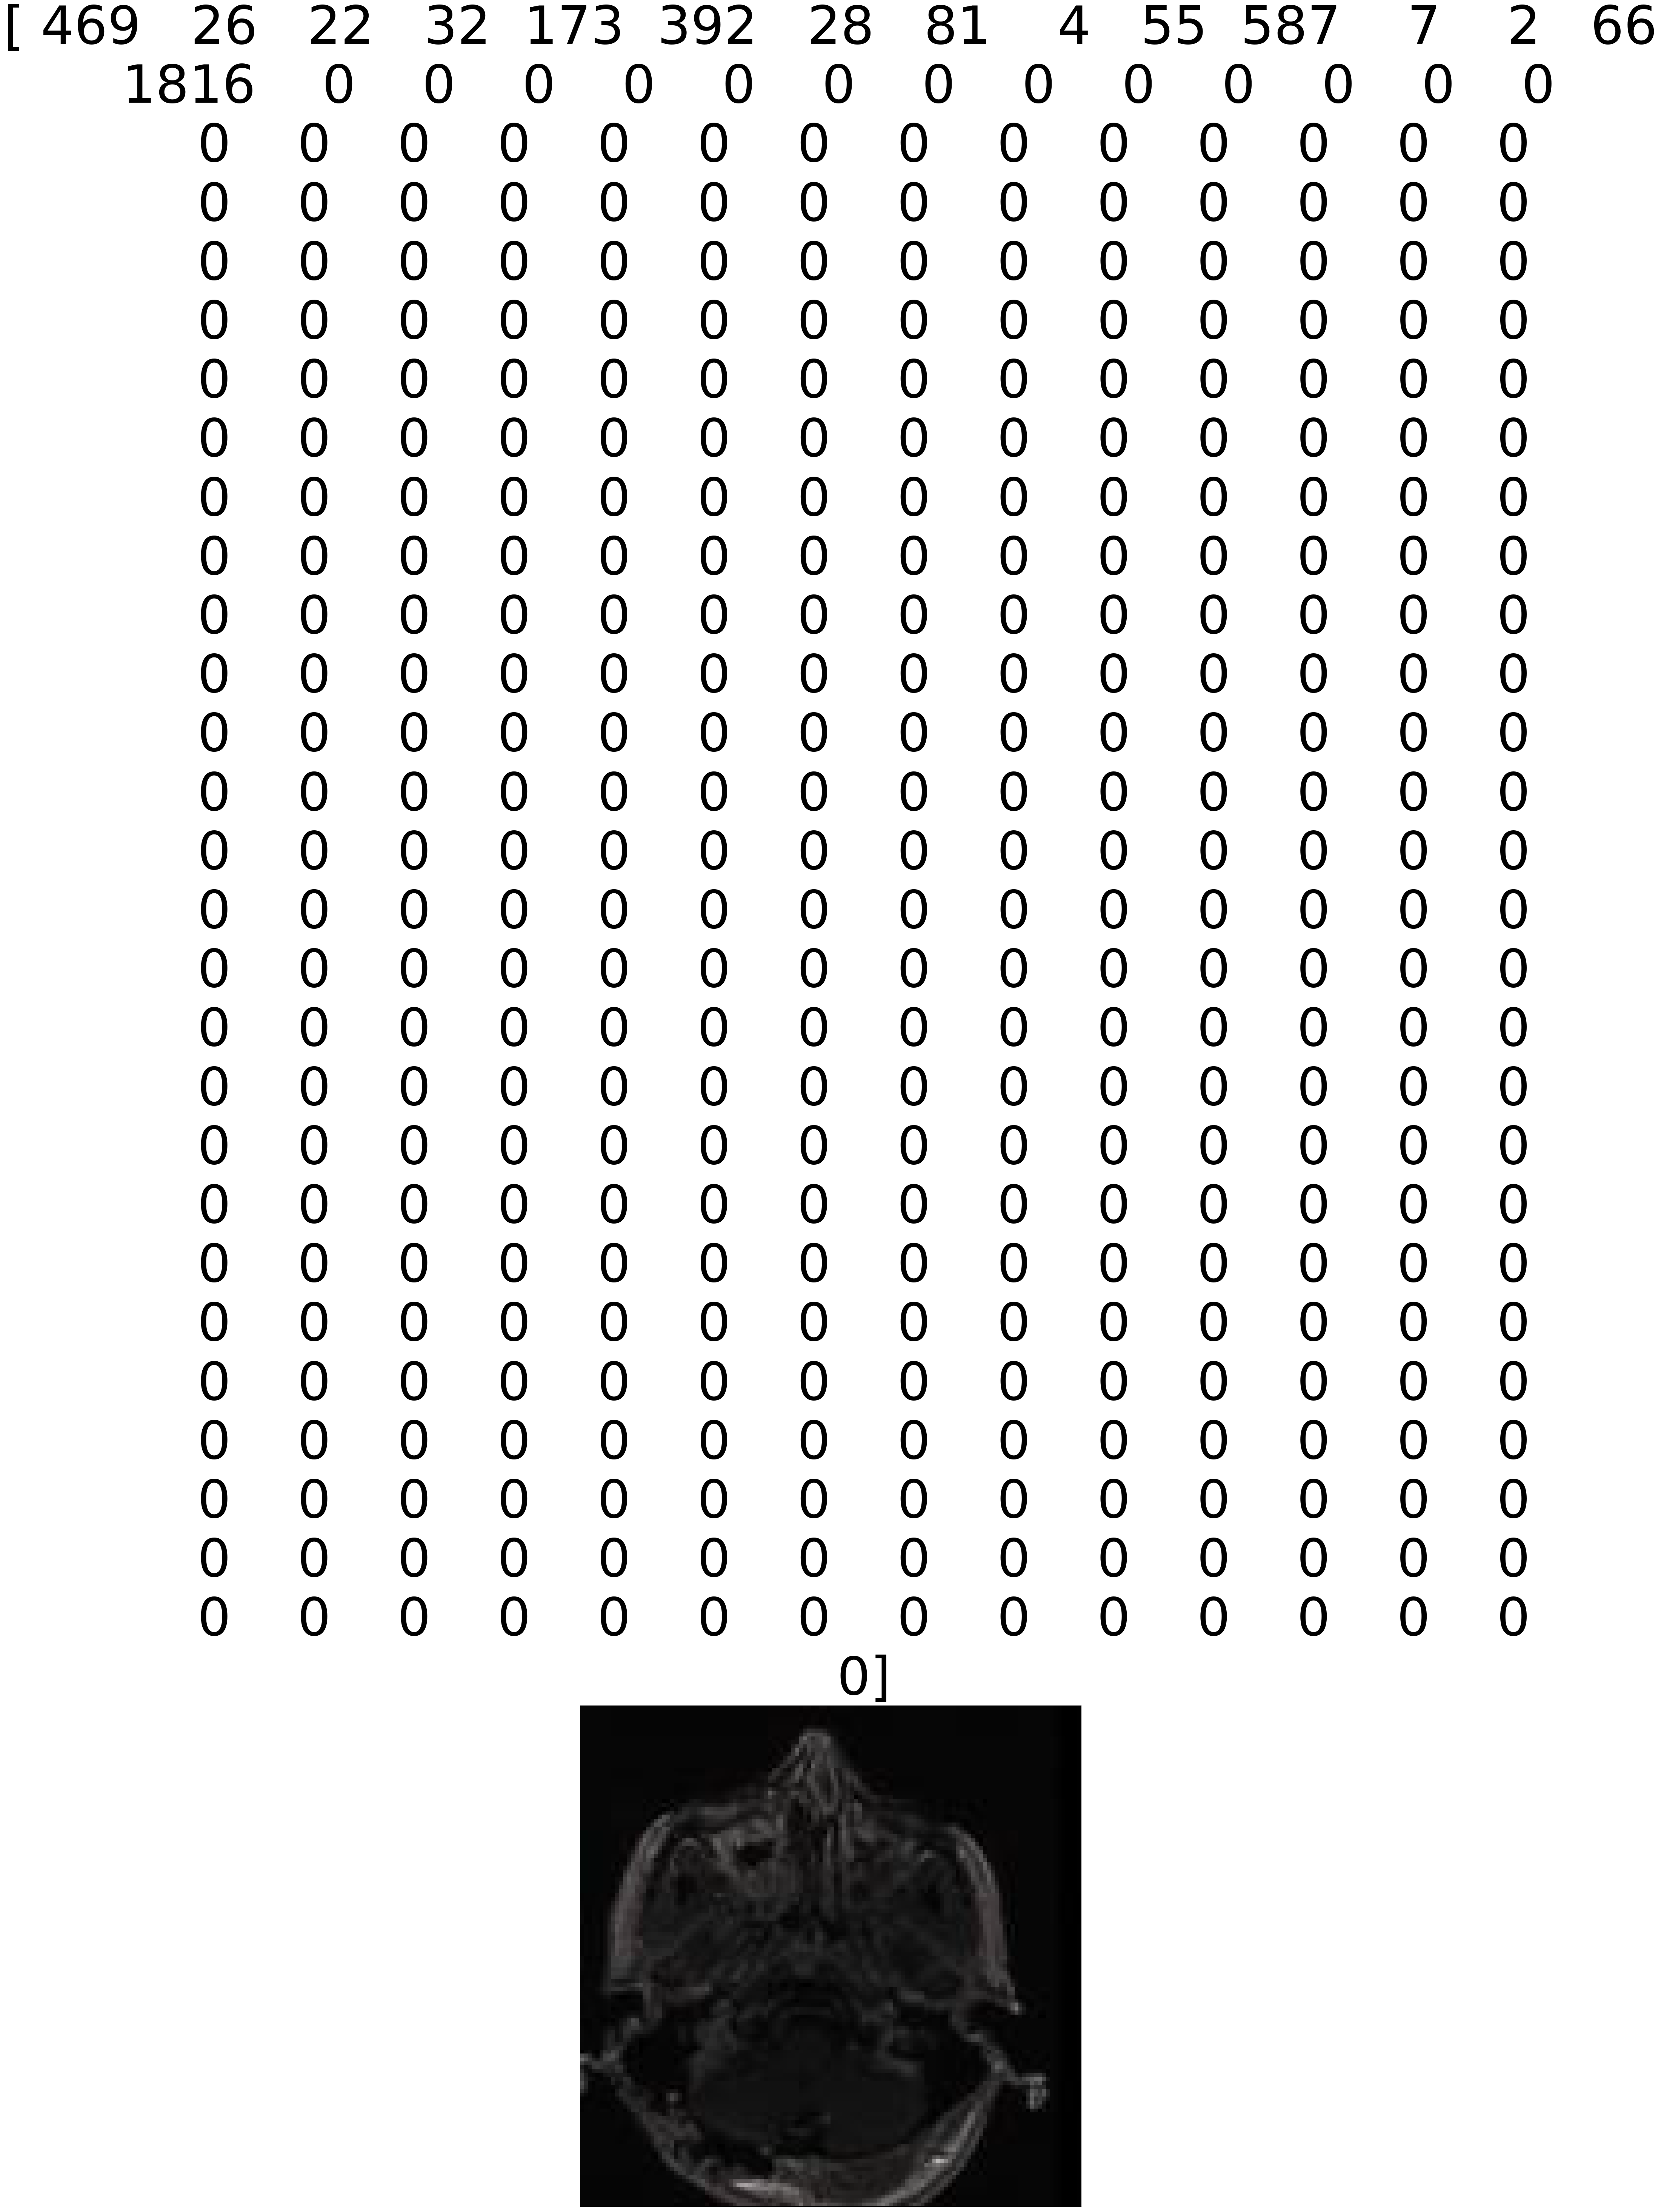

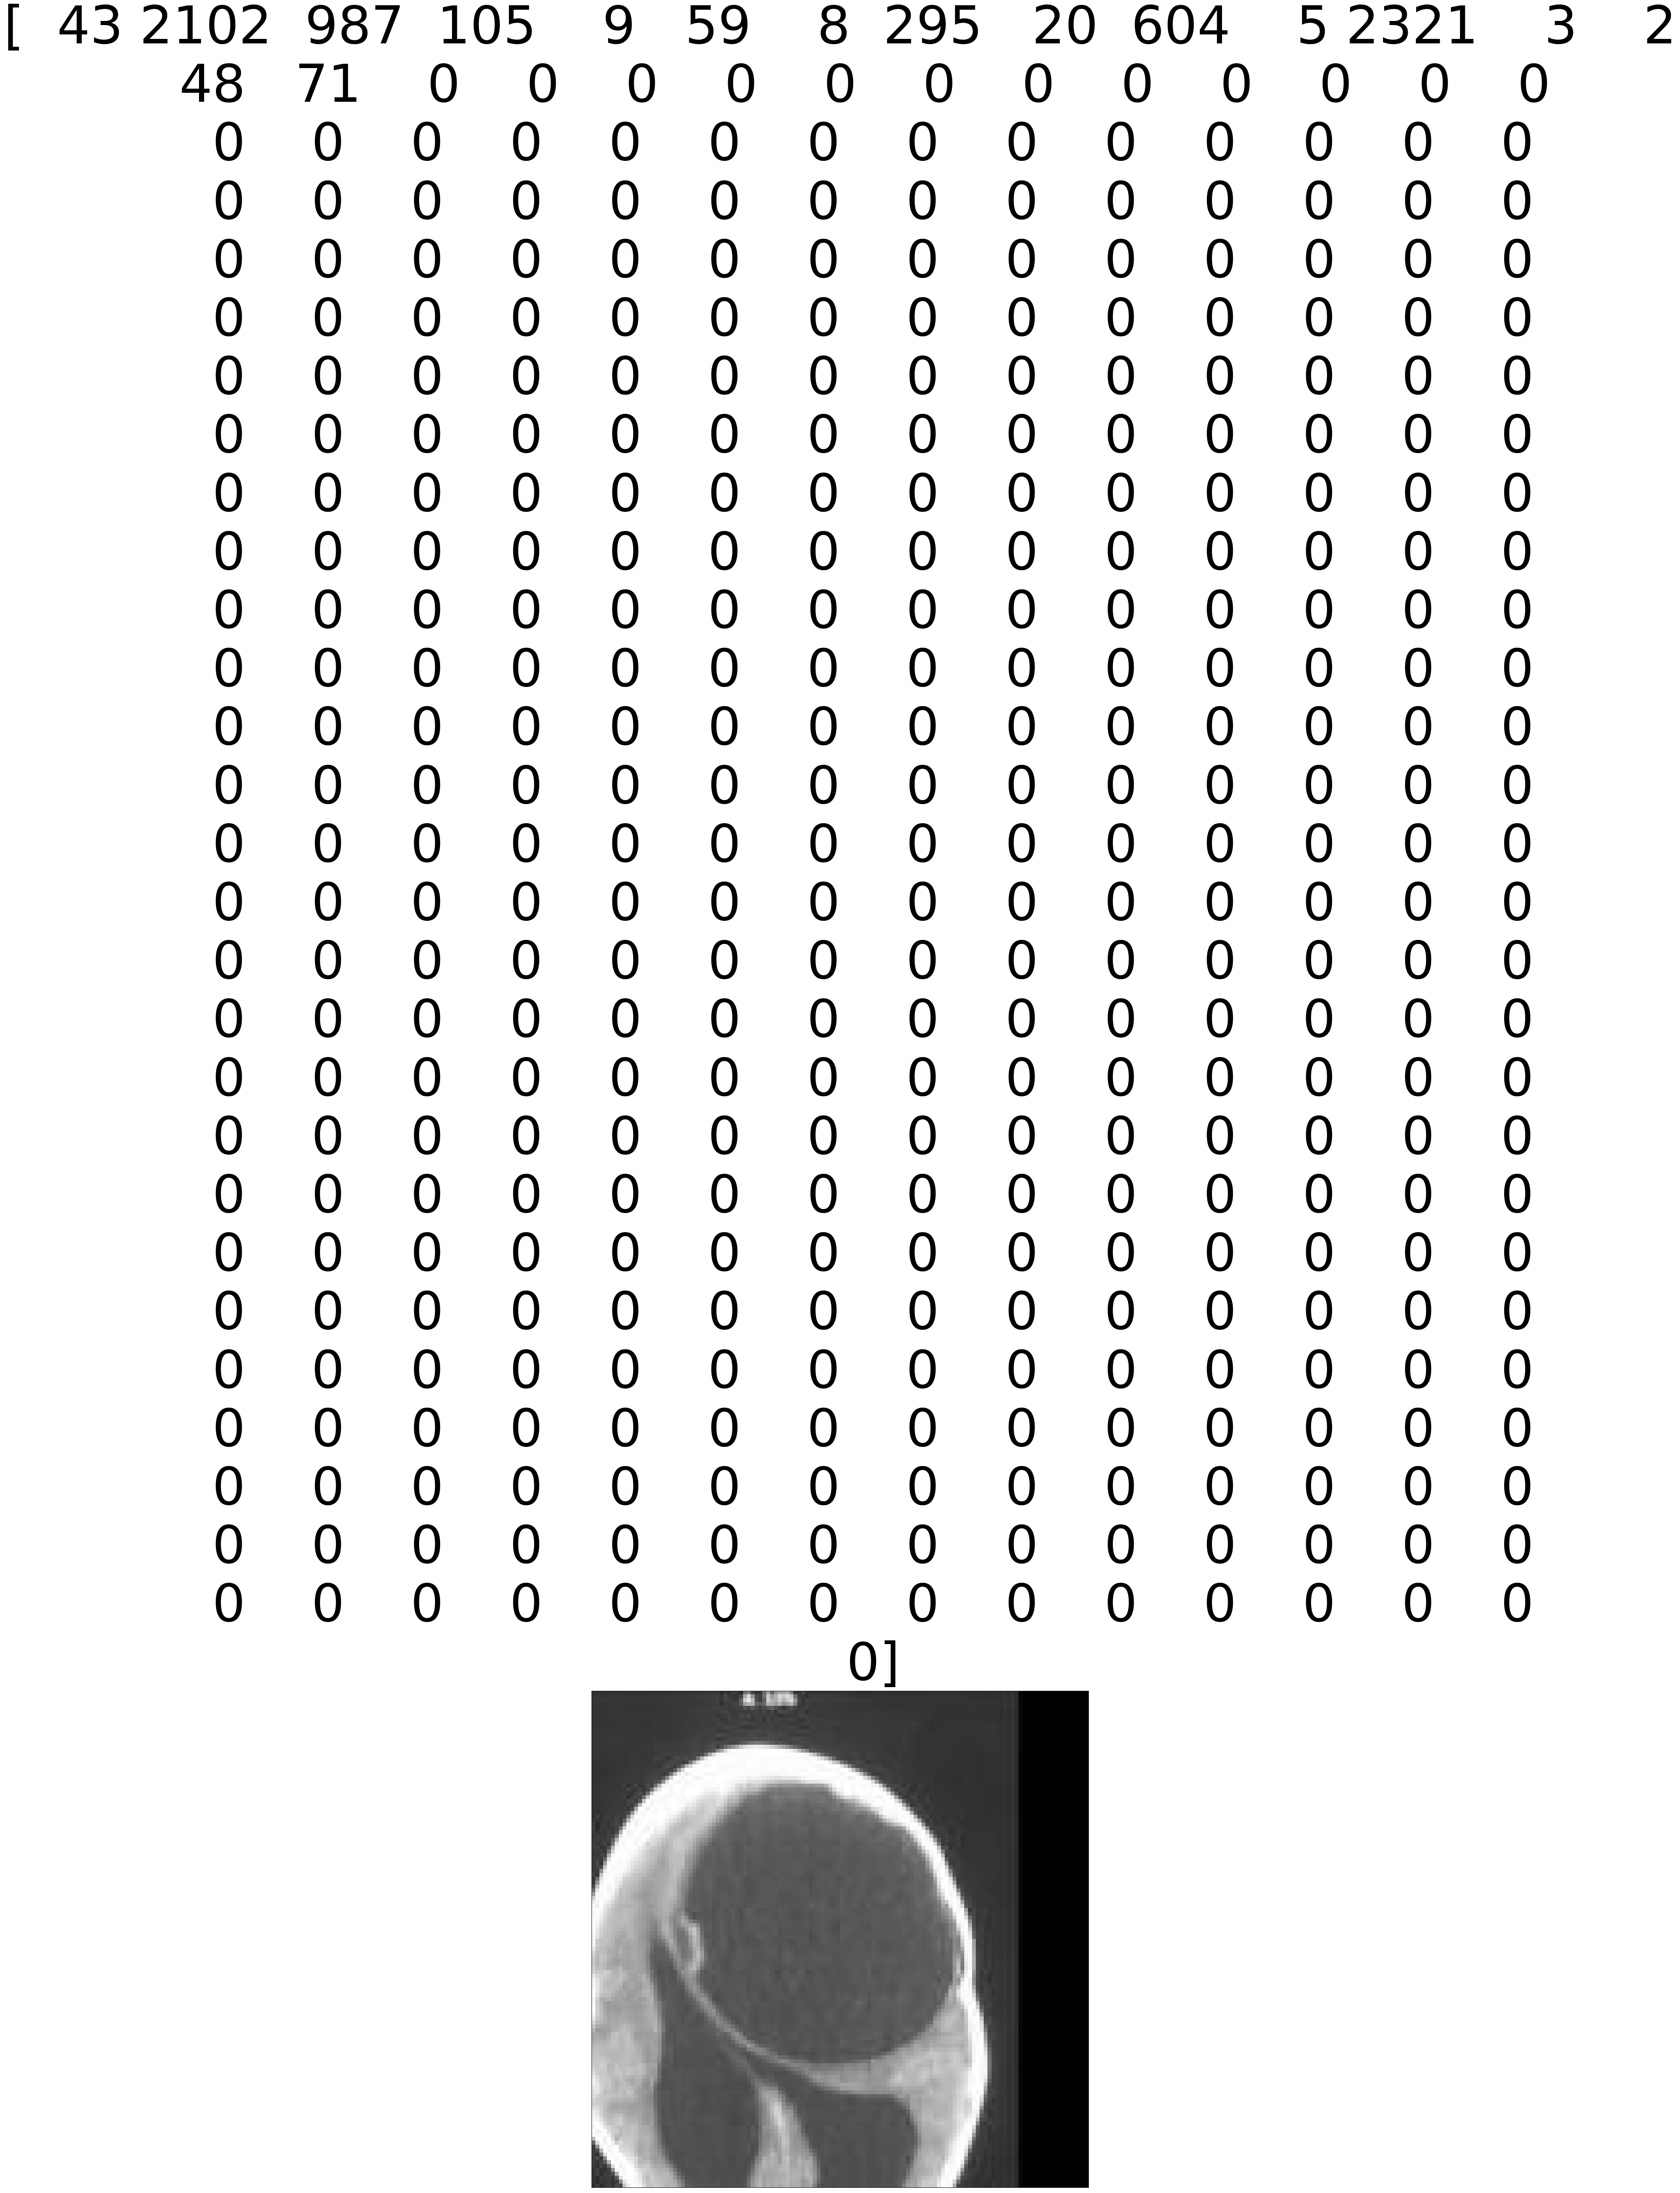

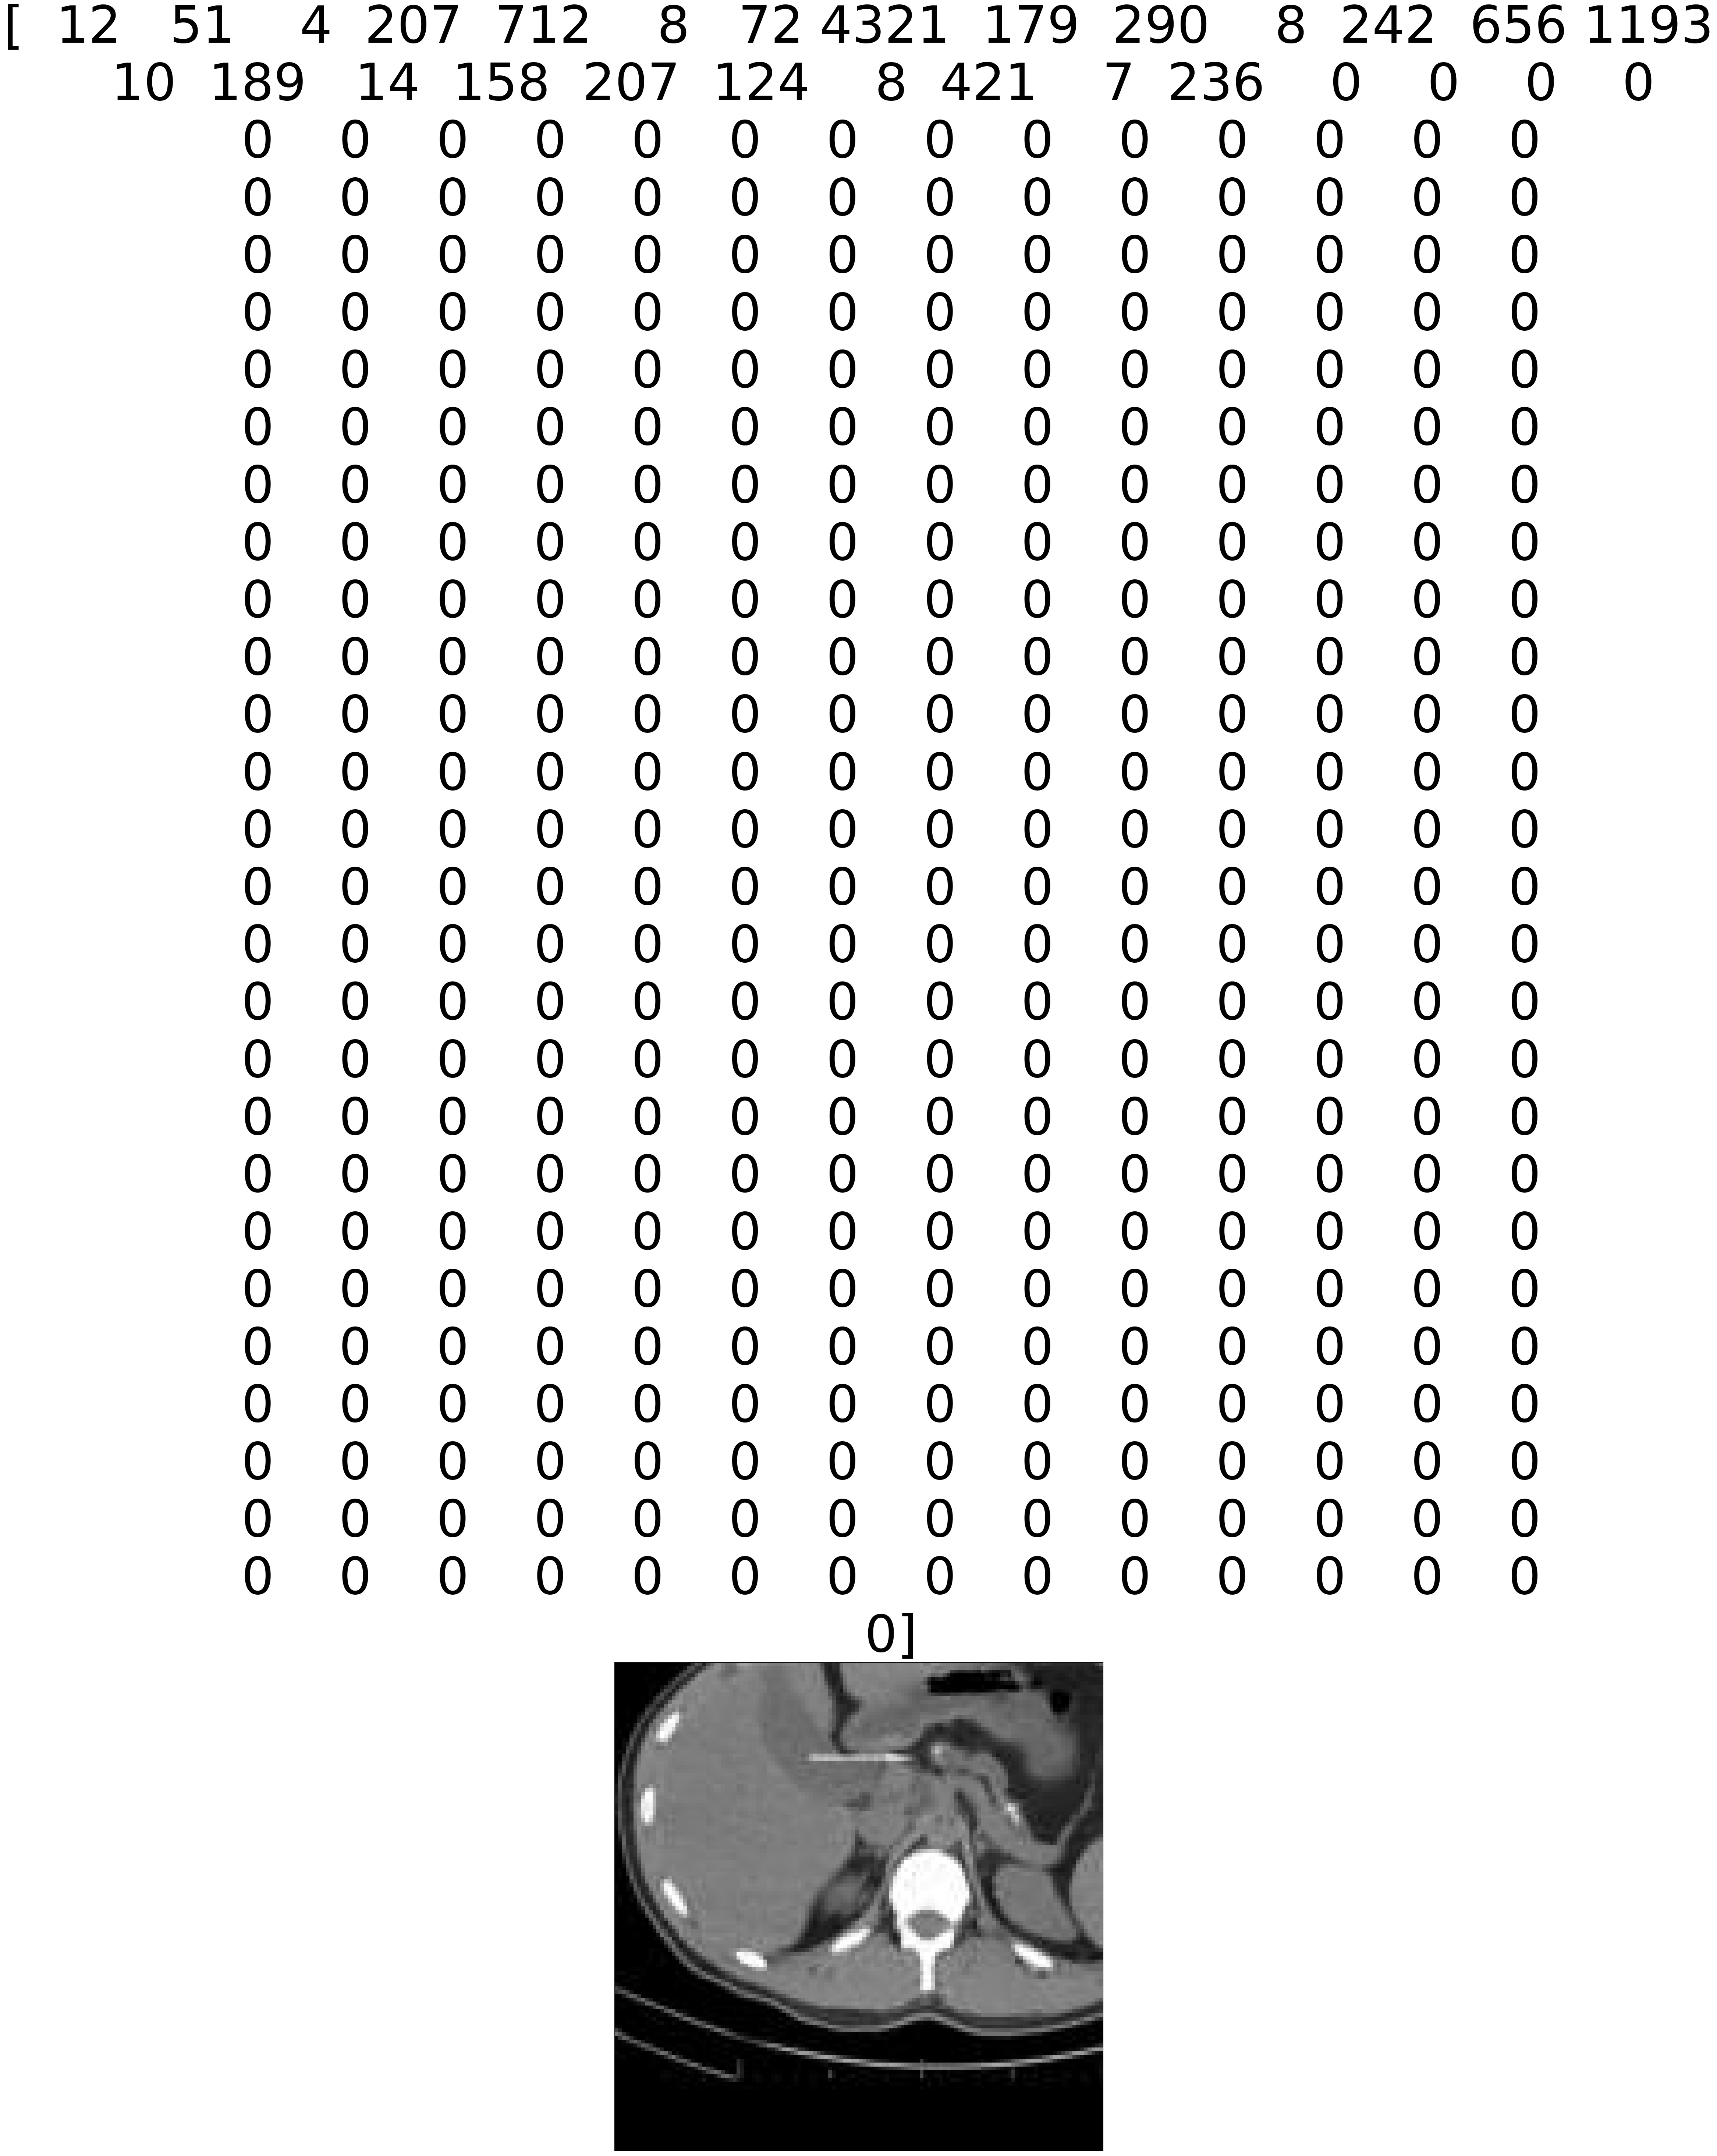

In [13]:
visualize_dataset(ds_train, 5)